In [1]:
# Add parent dir to path for utils access
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))

# Import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import rasterio 
import rioxarray as rio
import cf_xarray
import earthaccess
import seaborn as sns
import utilities.useful_functions as utils
from rasterio.enums import Resampling

# Define necessary specific fcns not incl'd in utils
def get_ci(ds, ndwi=False):
    """
    Calculates the Cyanobacteria Index (Wynne & Stumpf, 2015) for a given AOI.
    Args:
        ds - dataset of subsetted rhos w/ wavelength_3d as coord
        ndwi - whether to use NDWI to filter out land-contaminated edge pixels
    Returns:
        ci_stumpf - CI dataset
    """
    # Filter for NDWI, if applicable
    if ndwi:
        r560 = ds.sel({"wavelength_3d": 560}, method="nearest")
        r842 = ds.sel({"wavelength_3d": 842}, method="nearest")
        ndwi_ds = (r560 - r842) / (r560 + r842)
        ds = ds.where(ndwi_ds > 0.0, np.nan)

    # Grab CI bands and calculate
    r665 = ds.sel({"wavelength_3d": 665}, method="nearest")
    r681 = ds.sel({"wavelength_3d": 681}, method="nearest")
    r709 = ds.sel({"wavelength_3d": 709}, method="nearest")

    band_ratio = (681 - 665) / (709 - 665)
    ci_stumpf = ((r709 - r665)*band_ratio - (r681 - r665))
    ci_stumpf = ci_stumpf.where(np.logical_or((ci_stumpf >= 5.5e-5), 
                                              (np.isnan(ci_stumpf))), 0)
    
    return ci_stumpf.to_dataset(name="ci_stumpf")


#################################################################
#                         User Input                            #
#################################################################

# Set up known scenes; (w, s, e, n) as per earthaccess bounding_box
scenes = {"glakes":(-90, 41, -78, 46), "sagbay":(-84, 43.6, -83, 44.6),
          "eerie":(-83.5, 41.4, -82, 42.2), "okchb":(-81.2, 26.6, -80.5, 27.3),
          "gbay_winne":(-89, 43, -86, 46.5), "neagh":(-6.7, 54.4, -6.1, 54.9),
          "utah":(-112, 39.89, -111.6, 40.5),}

# Set up vars for specific event
scene = scenes["neagh"]
plot_ext = [scene[0],scene[2],scene[1],scene[3]]

# Times to grab granules from
tspan_1 = ("2025-07-13", "2025-07-13")
tspan_2 = ("2025-08-13", "2025-08-13")

# Plot title 
title = "Change in Cyanobacteria Index Over Time"

# Processing in the cloud?
in_the_cloud = False

In [2]:
# Set credentials
auth = earthaccess.login(persist=True)

In [3]:
# Grabbing granules
pre_results = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL_NRT",
    temporal=tspan_1,
    bounding_box=scene,
    cloud_cover=(0, 75)
)

bloom_results = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL_NRT",
    temporal=tspan_2,
    bounding_box=scene,
    cloud_cover=(0, 75)
)

pre_results[0]

Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_SFREFL_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 64.90695, 'Longitude': 20.46746}, {'Latitude': 57.10113, 'Longitude': -29.02246}, {'Latitude': 41.30299, 'Longitude': -14.0347}, {'Latitude': 47.2669, 'Longitude': 19.22563}, {'Latitude': 64.90695, 'Longitude': 20.46746}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-07-13T12:23:38Z', 'BeginningDateTime': '2025-07-13T12:18:39Z'}}
Size(MB): 740.2226724624634
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250713T121839.L2.SFREFL.V3_0.NRT.nc']

In [4]:
bloom_results[-1]

Collection: {'ShortName': 'PACE_OCI_L2_SFREFL_NRT', 'Version': '3.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 57.9516, 'Longitude': 16.90757}, {'Latitude': 51.13403, 'Longitude': -24.1898}, {'Latitude': 34.60379, 'Longitude': -12.74973}, {'Latitude': 40.22042, 'Longitude': 17.11599}, {'Latitude': 57.9516, 'Longitude': 16.90757}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-08-13T12:30:58Z', 'BeginningDateTime': '2025-08-13T12:25:59Z'}}
Size(MB): 729.2399263381958
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250813T122559.L2.SFREFL.V3_1.NRT.nc']

In [5]:
results = [pre_results[0], bloom_results[-1]]

if in_the_cloud:
    paths = earthaccess.open(results)
else:
    paths = earthaccess.download(results, local_path="local_data")
paths

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['local_data/PACE_OCI.20250713T121839.L2.SFREFL.V3_0.NRT.nc',
 'local_data/PACE_OCI.20250813T122559.L2.SFREFL.V3_1.NRT.nc']

In [6]:
# Keep original whole files for RGB underlay
nobloom, bloom = utils.open_nc(paths[0]), utils.open_nc(paths[1])

nobloom_sub, bloom_sub = utils.subset(nobloom, scene), utils.subset(bloom, scene)
nobloom_sub = utils.mask_ds(nobloom_sub, flag="LAND")
bloom_sub = utils.mask_ds(bloom_sub, flag="LAND")

/Users/sacaplan/mambaforge/envs/hhenv/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:234: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/sacaplan/mambaforge/envs/hhenv/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:234: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


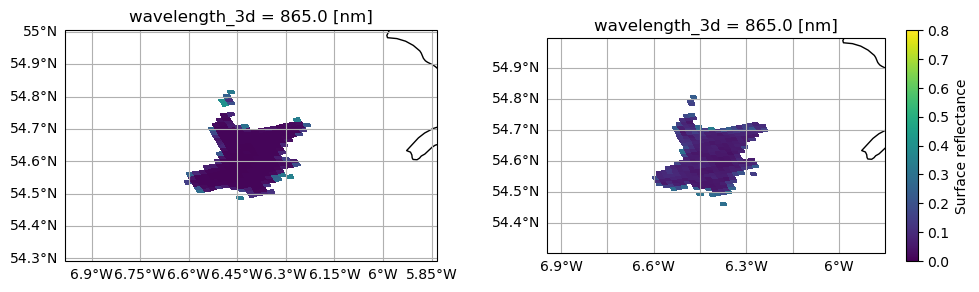

In [7]:
# Plot to make sure everything worked correctly 
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
nobloom_sub.rhos[:,:,110].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[0], add_colorbar=False)
bloom_sub.rhos[:,:,110].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[1])
plt.show()

In [8]:
# Project granules onto same grid
bloom_sub = utils.reproject_3d(bloom_sub["rhos"])
crs = bloom_sub.rio.crs
shape = bloom_sub.rio.shape
transform = bloom_sub.rio.transform()

nobloom_sub = utils.grid_match_3d(nobloom_sub["rhos"], 
                                  crs=crs,
                                  dst_shape=shape,
                                  transform=transform)

In [10]:
# Calculate CI
nobloom_ci, bloom_ci = get_ci(nobloom_sub, ndwi=False), get_ci(bloom_sub, ndwi=False)

In [11]:
# Make the RGBs from original data and reproject onto same grid
bloom_rgb = utils.make_rgb(bloom)
nobloom_rgb = utils.make_rgb(nobloom)

bloom_rgb = utils.grid_match_3d(bloom_rgb, crs=crs, dst_shape=shape,transform=transform)
nobloom_rgb = utils.grid_match_3d(nobloom_rgb, crs=crs, dst_shape=shape,transform=transform)

Image shape: (1710, 1272, 3)
Image shape: (1710, 1272, 3)


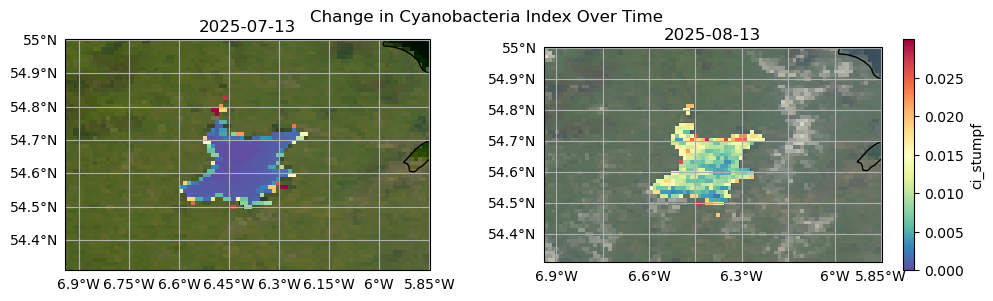

In [12]:
# Plot CI with RGB background
cbar_max = np.round(np.max(bloom_ci.ci_stumpf).data, 2)

# Clearly edge pixels for neagh non-bloom case, but NDWI overfilters for bloom case
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
nobloom_rgb.rgb.plot.imshow(ax=ax[0])
bloom_rgb.rgb.plot.imshow(ax=ax[1])
nobloom_ci.ci_stumpf.plot(x="longitude", y="latitude", vmin=0, vmax=cbar_max, ax=ax[0], 
                          cmap="Spectral_r", add_colorbar=False)
bloom_ci.ci_stumpf.plot(x="longitude", y="latitude", vmin=0, vmax=cbar_max, ax=ax[1], 
                        cmap="Spectral_r")
ax[0].set_title(f"{tspan_1[0]}")
ax[1].set_title(f"{tspan_2[0]}")
fig.suptitle(title)
plt.show()